### Definición de la función objetivo y su gradiente:

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import json
from scipy.optimize import minimize

def f(x):
    return np.arctan(x[0]**2 + x[1]**2) / np.exp(x[0]) 

# Gradiente:
def grad_f(x):
    df_dx = ((2*x[0] / (1 + (x[0]**2 + x[1]**2)**2)) - np.arctan(x[0]**2 + x[1]**2)) / np.exp(x[0])
    df_dy = 2 * x[1] / ((1 + (x[0]**2 + x[1]**2)**2) * np.exp(x[0]))
    return np.array([df_dx, df_dy])

### 🔹Implementación de Método de Máximo Descenso:
⚙️ Parámetros de entrada:

- x0 → punto inicial (vector donde comienza la búsqueda).

- grad_f → gradiente (∇f(x)) de la función objetivo.

- learning_rate → tamaño de paso.

- tol → tolerancia (si el cambio entre iteraciones es menor que este valor, se detiene el algoritmo).

- max_iter → número máximo de iteraciones permitidas.

⚙️ Resultados que devuelve:

- x_min → el último punto calculado (aproximación del mínimo de la función objetivo).

- history → lista con todos los puntos visitados.

- iteraciones → número de pasos realizados.

- succes → True si se detuvo por tolerancia, False si se agotaron las iteraciones.

- time → cuánto tardó en ejecutarse el algoritmo.

In [2]:
def gradient_descent(x0, grad_f, learning_rate=0.1, tol=1e-6, max_iter=100):
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    start = time.time()  

    for i in range(max_iter):
        grad = grad_f(x)
        
        x_new = x - learning_rate * grad
        history.append(x_new.copy())
        
        if np.linalg.norm(x_new - x) < tol:
            end = time.time()
            return x_new, history, i+1, True, end - start
        
        x = x_new

    end = time.time()
    
    return x, history, max_iter, False, end - start

### 🔹 Implementación del método Quasi-Newton (BFGS)

Elementos utilizados:

🔸 Clase `Callback`

Se utiliza para guardar los puntos intermedios (iteraciones) del algoritmo.

🔸función `minimize` de la biblioteca `scipy.optimize` 

Se utiliza para aplicar el **método BFGS (Broyden–Fletcher–Goldfarb–Shanno)**, la técnica de optimización **Quasi-Newton** explicada en el Informe Teórico

---

⚙️ Valores de entrada

- f → Función objetivo a minimizar.  
- x0 → Vector con el punto inicial de la búsqueda.  
- method='BFGS' → Especifica que se usará el método Quasi-Newton BFGS.  
- jac=grad_f → Indica la función que calcula el gradiente de `f`.  
- callback=callback → Función auxiliar que almacena los puntos visitados durante la optimización.  
- options → Diccionario con parámetros de configuración del método:
  - `'gtol': 1e-6` → Criterio de parada basado en la norma del gradiente.  
  - `'disp': False` → Desactiva la impresión de resultados en consola.  
  - `'maxiter': 100` → Número máximo de iteraciones permitidas.

---
⚙️ Resultados que devuelve

- x_qn → Vector con el punto final del proceso (aproximación del mínimo).

- hist_qn → Lista con todos los puntos visitados durante la optimización (trayectoria).

- iterations → número de pasos realizados.

- succes → True si se detuvo por tolerancia, False si se agotaron las iteraciones.

- time_qn → Tiempo total de ejecución del método.

In [3]:
def quasi_newton_method(f, grad_f, x0, tol=1e-6, max_iter=100):
    class Callback:
            def __init__(self):
                self.history = []
            def __call__(self, xk):
                self.history.append(np.array(xk))

    callback = Callback()

    start = time.time()

    res = minimize(f, x0, method='BFGS', jac=grad_f, callback=callback,
        options={'gtol': tol, 'disp': False, 'maxiter': max_iter})
    
    elapsed_time = time.time() - start

    # Results
    x_min = res.x
    history = [np.array(x0)] + callback.history
    iterations = res.nit
    success = res.success

    return x_min, history, iterations, success, elapsed_time

### Funcion para graficar los resultados:

In [4]:
def plot_convergence(history_gd, history_qn, experiment_name, x0):
    """
    Grafica la convergencia de ambos métodos en escala logarítmica
    """
    # Calcular la norma de los puntos en cada iteración
    norms_gd = [np.linalg.norm(np.array(point)) for point in history_gd]
    norms_qn = [np.linalg.norm(np.array(point)) for point in history_qn]
    
    # Calcular las diferencias entre iteraciones consecutivas
    diffs_gd = []
    if len(history_gd) > 1:
        diffs_gd = [np.linalg.norm(np.array(history_gd[i]) - np.array(history_gd[i-1])) 
                    for i in range(1, len(history_gd))]
    
    diffs_qn = []
    if len(history_qn) > 1:
        diffs_qn = [np.linalg.norm(np.array(history_qn[i]) - np.array(history_qn[i-1])) 
                    for i in range(1, len(history_qn))]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Gráfica 1: Norma de x vs iteraciones
    iterations_gd = range(len(norms_gd))
    iterations_qn = range(len(norms_qn))
    
    ax1.semilogy(iterations_gd, norms_gd, 'bo-', label='Gradient Descent', alpha=0.7, markersize=4)
    ax1.semilogy(iterations_qn, norms_qn, 'ro-', label='Quasi-Newton', alpha=0.7, markersize=4)
    ax1.set_xlabel('Iteración')
    ax1.set_ylabel('||x|| (log scale)')
    ax1.set_title(f'Convergencia de ||x||\nPunto inicial: {x0}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfica 2: Diferencia entre iteraciones
    if diffs_gd:  # Solo graficar si hay diferencias
        ax2.semilogy(range(1, len(diffs_gd)+1), diffs_gd, 'bo-', label='Gradient Descent', alpha=0.7, markersize=4)
    if diffs_qn:  # Solo graficar si hay diferencias
        ax2.semilogy(range(1, len(diffs_qn)+1), diffs_qn, 'ro-', label='Quasi-Newton', alpha=0.7, markersize=4)
    ax2.set_xlabel('Iteración')
    ax2.set_ylabel('||xₖ - xₖ₋₁|| (log scale)')
    ax2.set_title('Diferencia entre iteraciones consecutivas')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Gráfica 3: Trayectoria en 2D 
    if len(history_gd[0]) == 2:
        x_gd = [point[0] for point in history_gd]
        y_gd = [point[1] for point in history_gd]
        x_qn = [point[0] for point in history_qn]
        y_qn = [point[1] for point in history_qn]
        
        ax3.plot(x_gd, y_gd, 'bo-', label='Gradient Descent', alpha=0.7, markersize=4)
        ax3.plot(x_qn, y_qn, 'ro-', label='Quasi-Newton', alpha=0.7, markersize=4)
        ax3.plot(x_gd[0], y_gd[0], 'g*', markersize=15, label='Inicio', markeredgecolor='black')
        ax3.plot(x_gd[-1], y_gd[-1], 'k*', markersize=15, label='Final GD', markeredgecolor='white')
        ax3.plot(x_qn[-1], y_qn[-1], 'm*', markersize=15, label='Final QN', markeredgecolor='white')
        ax3.set_xlabel('x₁')
        ax3.set_ylabel('x₂')
        ax3.set_title('Trayectoria de convergencia')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.axis('equal')
    
    # Gráfica 4: Valor de la función objetivo 
    try:
        # Intentar calcular f(x) para cada punto
        f_values_gd = [f(np.array(point)) for point in history_gd]
        f_values_qn = [f(np.array(point)) for point in history_qn]
        
        ax4.semilogy(iterations_gd, f_values_gd, 'bo-', label='Gradient Descent', alpha=0.7, markersize=4)
        ax4.semilogy(iterations_qn, f_values_qn, 'ro-', label='Quasi-Newton', alpha=0.7, markersize=4)
        ax4.set_xlabel('Iteración')
        ax4.set_ylabel('f(x) (log scale)')
        ax4.set_title('Convergencia del valor objetivo')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    except:
        ax4.text(0.5, 0.5, 'No se pudo calcular f(x)', 
                horizontalalignment='center', verticalalignment='center',
                transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Valor de la función objetivo')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabla resumen 
    print("\n" + "="*80)
    print(f"RESUMEN PARA PUNTO INICIAL: {x0}")
    print("="*80)
    print(f"{'Métrica':<25} {'Gradient Descent':<20} {'Quasi-Newton':<20}")
    print("-"*80)
    print(f"{'Iteraciones totales':<25} {len(history_gd):<20} {len(history_qn):<20}")
    print(f"{'Norma final ||x||':<25} {norms_gd[-1]:<20.6f} {norms_qn[-1]:<20.6f}")
    
    last_diff_gd = diffs_gd[-1] if diffs_gd else "N/A"
    last_diff_qn = diffs_qn[-1] if diffs_qn else "N/A"
    
    # Formatear correctamente según el tipo de dato
    if isinstance(last_diff_gd, str):
        diff_gd_str = f"{last_diff_gd:<20}"
    else:
        diff_gd_str = f"{last_diff_gd:<20.6e}"
        
    if isinstance(last_diff_qn, str):
        diff_qn_str = f"{last_diff_qn:<20}"
    else:
        diff_qn_str = f"{last_diff_qn:<20.6e}"
    
    print(f"{'Última diferencia':<25} {diff_gd_str} {diff_qn_str}")
    print("="*80)

### Función `Experiment`

La función `Experiment` permite automatizar la ejecución de experimentos de optimización para distintos parámetros iniciales y configuraciones. Su funcionamiento resumido es el siguiente:

1. **Lectura de configuraciones:** Carga un archivo JSON (`experiment_name`) que contiene los parámetros de cada experimento, como punto inicial, tolerancia, tasa de aprendizaje y número máximo de iteraciones.

2. **Ejecución de métodos de optimización:**  
   - Aplica el **Método de Máximo Descenso** (`gradient_descent`) con los parámetros especificados.  
   - Aplica el **Método Quasi-Newton** (`quasi_newton_method`) con los mismos parámetros.

3. **Registro de resultados:** Para cada experimento, guarda:
   - Las coordenadas finales (`x_min`) y el valor mínimo de la función (`f_min`).  
   - Número de iteraciones realizadas y si el método convergió.  
   - Tiempo de ejecución de cada método.

4. **Almacenamiento de resultados:** Todos los resultados se guardan en un archivo JSON llamado `results_<experiment_name>` para su posterior análisis.

In [5]:
def Experiment(experiment_name):
    # Leer configuraciones desde archivo JSON
    with open(experiment_name, "r") as f_in:
        configs = json.load(f_in)

    resultados = []

    for idx, cfg in enumerate(configs):
        # Aplicar Método de Máximo Descenso
        x_min_gd, history_gd, num_iter_gd, converged_gd, elapsed_gd = gradient_descent(
            cfg["x0"], grad_f,
            learning_rate=cfg["learning_rate"],
            tol=cfg["tol"],
            max_iter=cfg["max_iter"]
        )

        # Aplicar Método de Quasi-Newton
        x_min_qn, history_qn, iterations_qn, success_qn, elapsed_qn = quasi_newton_method(
            f, grad_f,
            x0=cfg["x0"],
            tol=cfg["tol"],
            max_iter=cfg["max_iter"]
        )

        history_gd_list = [x.tolist() for x in history_gd]
        history_qn_list = [x.tolist() for x in history_qn]

        plot_convergence(history_gd_list, history_qn_list, experiment_name, cfg["x0"])

        #Guardar ambos resultados
        resultados.append({
            "params": cfg,

            # Resultados de Gradiente Descendente
            "gradient_descent": {
                "x_min": x_min_gd.tolist(),
                "f_min": float(f(x_min_gd)),
                "num_iter": num_iter_gd,
                "converged": converged_gd,
                "time_seconds": elapsed_gd
            },

            # Resultados de Quasi-Newton
            "quasi_newton": {
                "x_min": x_min_qn.tolist(),
                "f_min": float(f(x_min_qn)),
                "num_iter": iterations_qn,
                "converged": success_qn,
                "time_seconds": elapsed_qn
            }
        })

    # Guardar resultados en archivo JSON
    with open(f"results_{experiment_name}", "w") as f_out:
        json.dump(resultados, f_out, indent=4)

    print("✅ Experimento completado.")

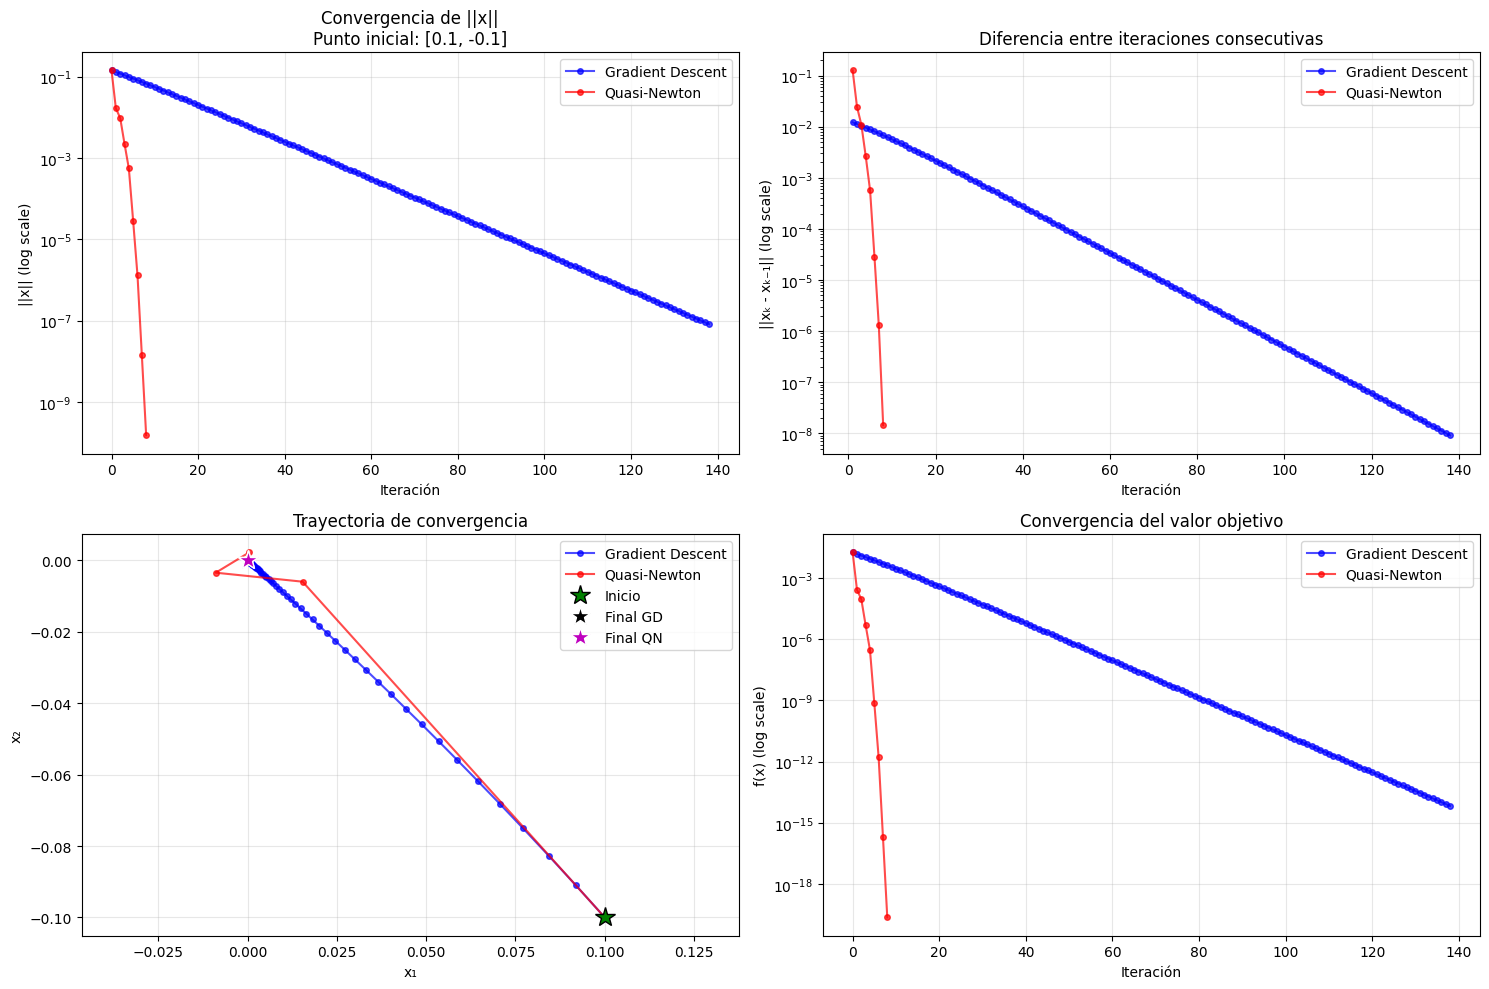


RESUMEN PARA PUNTO INICIAL: [0.1, -0.1]
Métrica                   Gradient Descent     Quasi-Newton        
--------------------------------------------------------------------------------
Iteraciones totales       139                  9                   
Norma final ||x||         0.000000             0.000000            
Última diferencia         9.103403e-09         1.433295e-08        


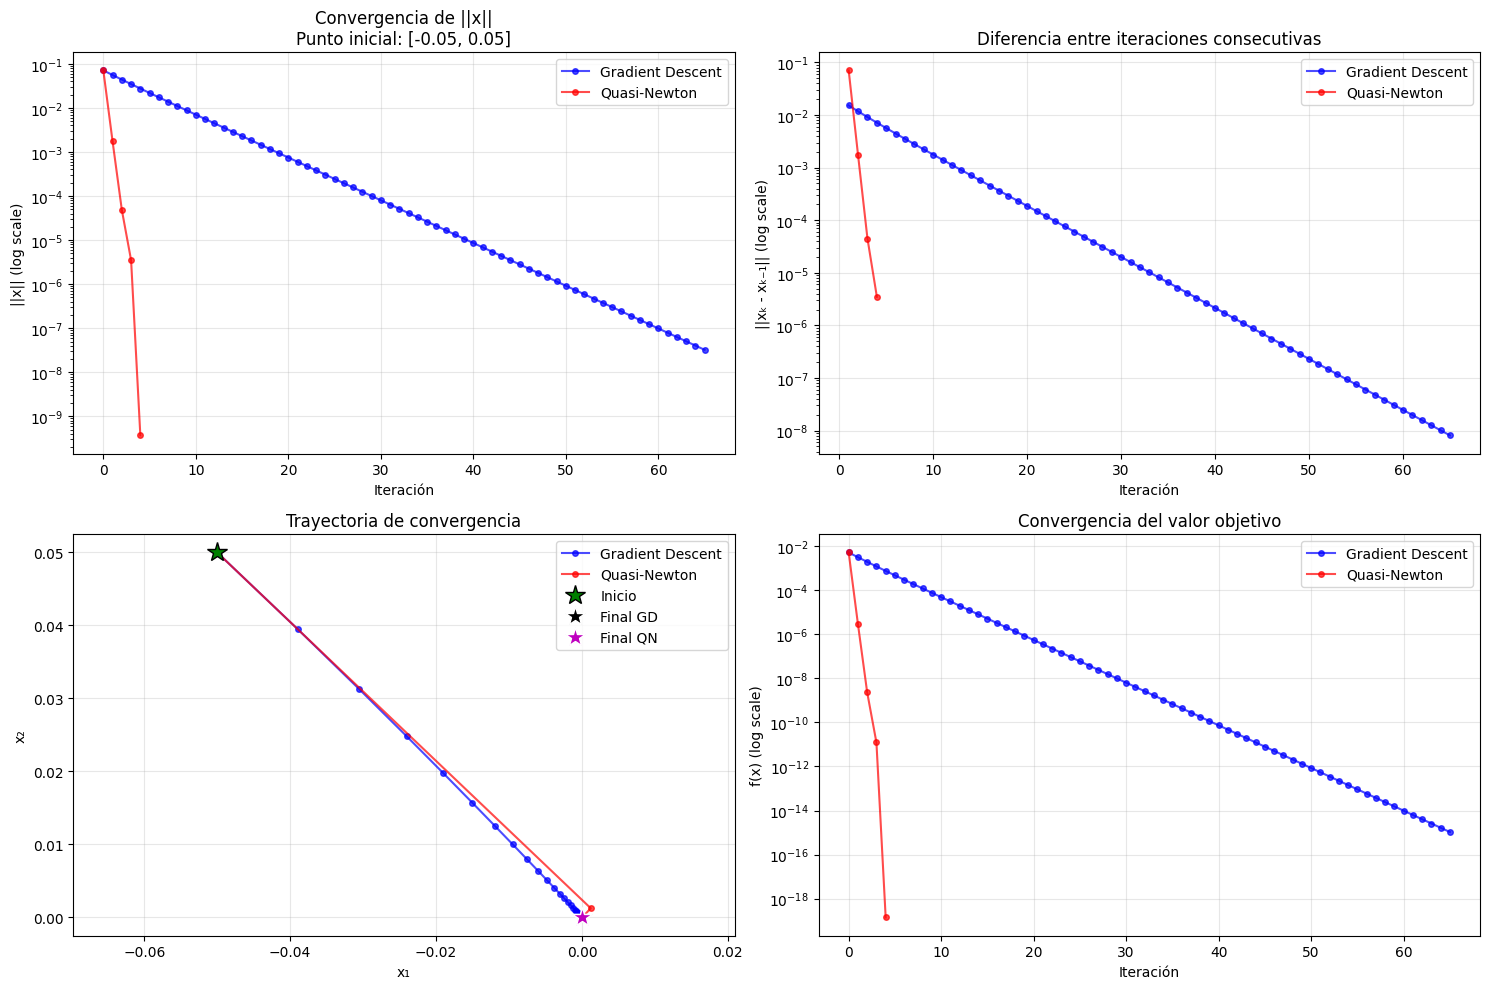


RESUMEN PARA PUNTO INICIAL: [-0.05, 0.05]
Métrica                   Gradient Descent     Quasi-Newton        
--------------------------------------------------------------------------------
Iteraciones totales       66                   5                   
Norma final ||x||         0.000000             0.000000            
Última diferencia         8.106953e-09         3.504851e-06        


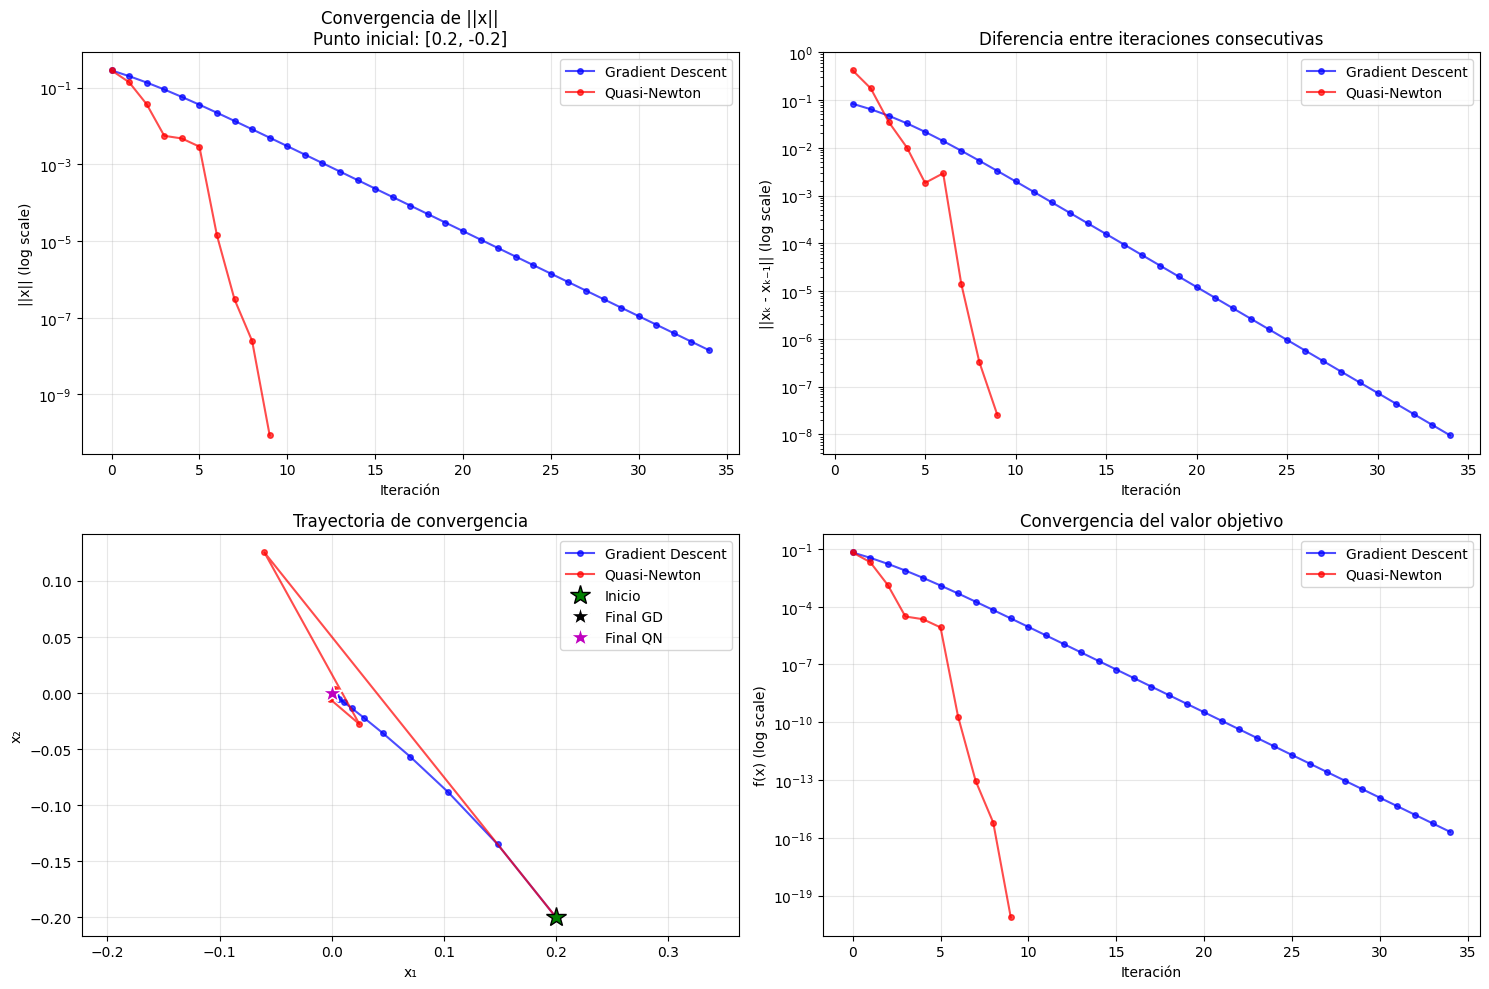


RESUMEN PARA PUNTO INICIAL: [0.2, -0.2]
Métrica                   Gradient Descent     Quasi-Newton        
--------------------------------------------------------------------------------
Iteraciones totales       35                   10                  
Norma final ||x||         0.000000             0.000000            
Última diferencia         9.516585e-09         2.495149e-08        


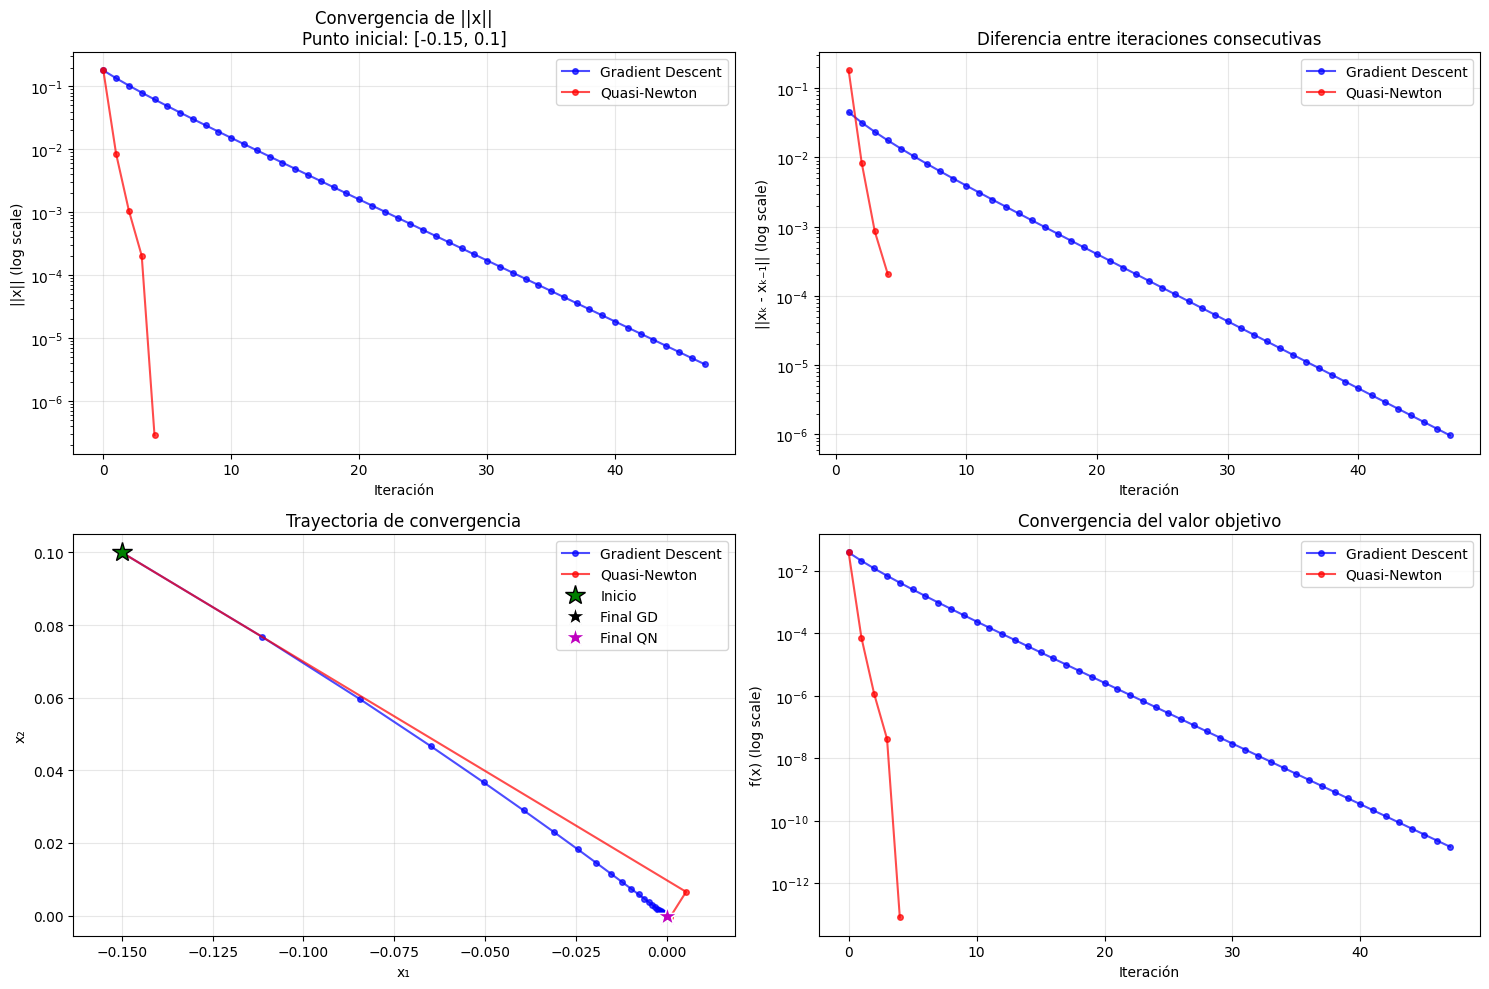


RESUMEN PARA PUNTO INICIAL: [-0.15, 0.1]
Métrica                   Gradient Descent     Quasi-Newton        
--------------------------------------------------------------------------------
Iteraciones totales       48                   5                   
Norma final ||x||         0.000004             0.000000            
Última diferencia         9.672232e-07         2.049295e-04        


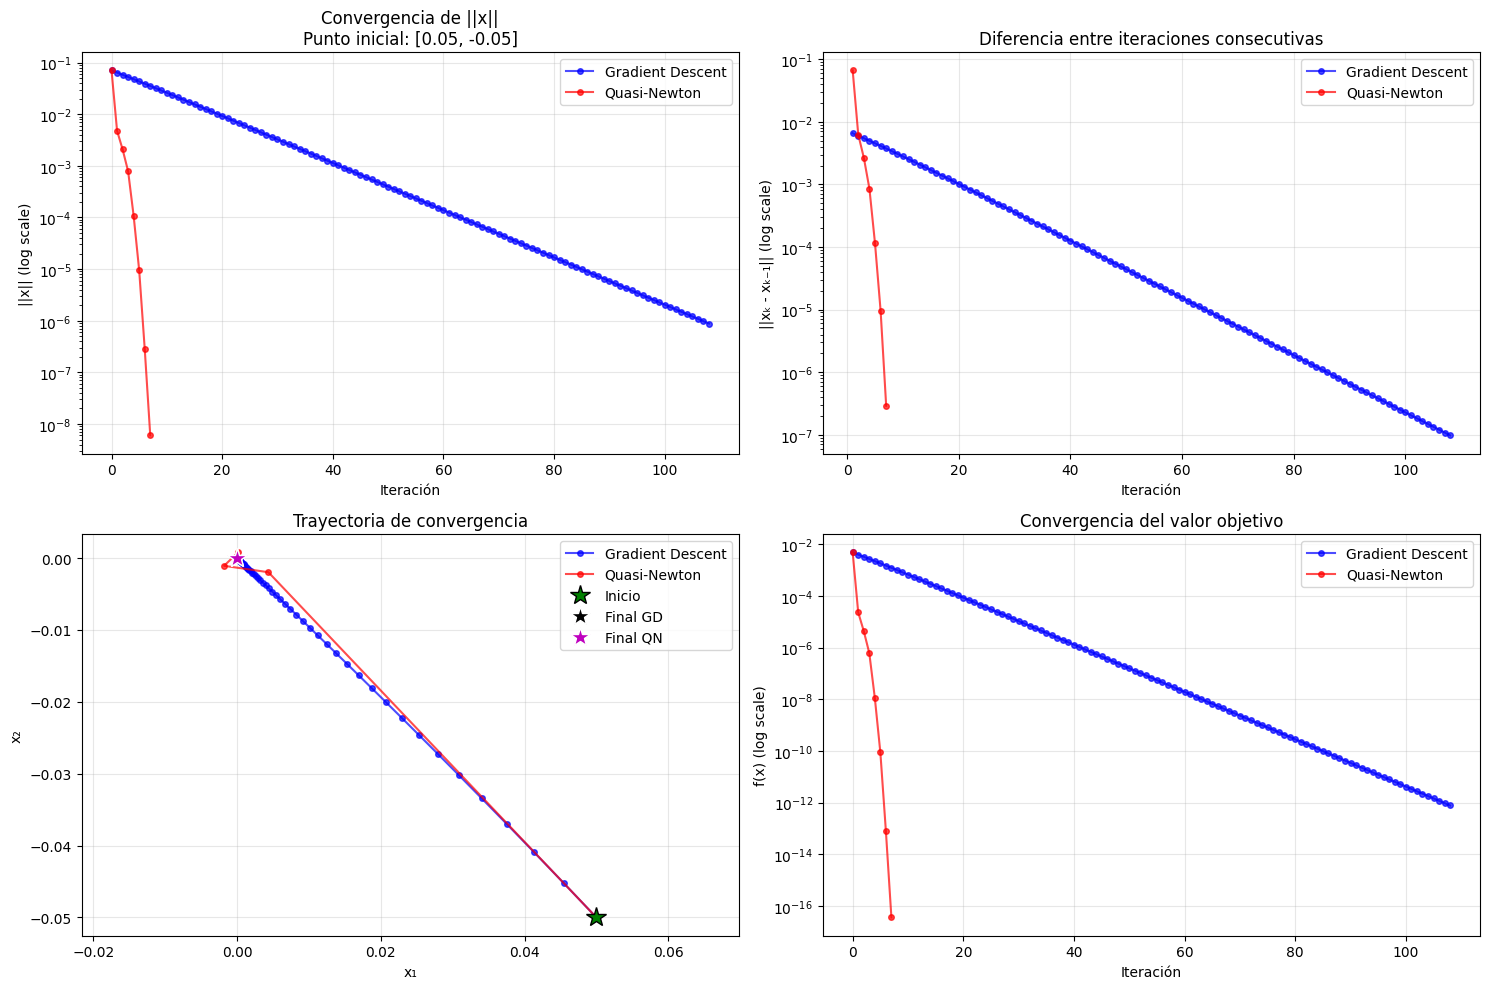


RESUMEN PARA PUNTO INICIAL: [0.05, -0.05]
Métrica                   Gradient Descent     Quasi-Newton        
--------------------------------------------------------------------------------
Iteraciones totales       109                  8                   
Norma final ||x||         0.000001             0.000000            
Última diferencia         9.791599e-08         2.907890e-07        
✅ Experimento completado.


In [6]:
Experiment("exp1.json")